### Performing Naive Bayesian Classifier,and ROC/AUC analysis on data

- #### Procedures:
    - ##### 1.The proccess for whole features
        - ##### 1.1.Implement a NB classifier
        - ##### 1.2.Train data with cross validation to calculate the avarage accuracy suing 0/1 loss and observe average accuracy
        - ##### 1.3.Split train data into cross_train and cross_test to observe the accuracy（0/1 loss),draw the ROC and calculate AUC and confusion matrix with evaluation
    - ##### 2.The proccess for subset of features by feature extraction
        - ##### 2.1.Train data with cross validation to calculate the avarage accuracy and observe average accuracy
        - ##### 2.2.Split train data into cross_train and cross_test to observe the accuracy（0/1 loss),draw the ROC and calculate AUC and confusion matrix with evaluation 
        - ##### 2.3.Predict the Y_test for submission with the classifier
    - ##### 3.Compare the performance of NB with whole features and subset of features with feature extraction

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score 
from collections import Counter
from random import seed
from random import randrange
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
%matplotlib inline

### 1.The proccess for whole features

#### 1.1:  Implement a NB classifier


##### First: Load classification data
Download `X_train.csv` and `X_test.csv`,`y_train.csv` from Moodle. In X_train.csv, each row corresponds to an instance.the columns representing all of the features. The same format is used in `X_test.csv`. Load these datasets into python (numpy.loadtxt) and create an X matrix consisting of 112 columns and a Y_train as training t. Do the same for the test data so we have four objects: $\mathbf{X}_{train}$, $\mathbf{X}_{test}$, and $\mathbf{Y}_{train}$.and normalize the data

In [2]:
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
Y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1][:,None]

rec_arr = np.genfromtxt("X_train.csv", delimiter = ",", names=True, dtype=None)
feature_list = []
for i in rec_arr.dtype.names:
    feature_list.append(i)
feature_list.pop(86)

feature_list = np.array(feature_list)

# Make an instance of the Model
# remove constant features
thresholder = VarianceThreshold(threshold=0)
X_train = thresholder.fit_transform(X_train)
X_test = thresholder.transform(X_test)
# normalize the data 

feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

##### Second: implement a NB classifier 

##### Third 1: Write the nb_train function to get the mean and variance for each class 
We use Gaussian distributions for each class. first compute the mean and variance). The prior for each class will be the proportion of training data in that class.

##### Third 2: Write function to make prediction on testX with the trained Gaussian Naive Bayes classifier 

Computing the likelihood for each class using the mean and variance calculated and multiplying by the prior, and then normalise it. the function will also returns the probability of assigning the test data to each class.

In [3]:
def nb_train(X_train, y_train):
    priori = dict()
    counter = Counter(y_train)
    for label, counts in counter.items():
        priori[label] = counts / len(y_train)
    stats = dict()
    for label in set(y_train):
        indices = np.where(y_train == label)[0]
        stats[label] = dict()
        stats[label]['mean'] = X_train[indices].mean(axis=0)
        stats[label]['var'] = X_train[indices].var(axis=0)

    return priori, stats

In [4]:
def nb_predict(priori, stats, sample):
    post = {k: v for k, v in priori.items()}
    for label in priori.keys():
        mean = stats[label]['mean']
        var = stats[label]['var']
        p = 1. / (np.sqrt(2 * np.pi) * var) * np.exp(- (sample - mean) ** 2 / (2 * var ** 2))

        post[label] *= np.prod(p)
        
    s = sum(post.values())
    for label in post:
        post[label] /= s
    pred = max(post, key=lambda x: post[x])
    return post, pred


def predict(priori, stats, data):
    p = [nb_predict(priori, stats, sample) for sample in data]
    p_label = np.array([item[1] for item in p])
    prob = np.array([item[0][2.] for item in p])
    return p_label, prob

##### 1.2.Train data with cross validation to calculate the avarage accuracy suing 0/1 loss and observe average accuracy

In [5]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets

#Predict Output

kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

results = []

for train_index, test_index in kf.split(X_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    cross_fold_X_train, cross_fold_X_test = X_train[train_index], X_train[test_index]
    cross_fold_Y_train, cross_fold_Y_test = Y_train[train_index].flatten(), Y_train[test_index].flatten()
    
    #cross_fold_priori, cross_fold_stats = nb_train(cross_fold_X_train, cross_fold_Y_train)
    #cross_fold_y_test_pred, cross_fold_y_test_prob = predict(cross_fold_priori, cross_fold_stats, cross_fold_X_test)
    model.fit(cross_fold_X_train,cross_fold_Y_train)
    cross_fold_y_test_pred = model.predict(cross_fold_X_test)
    results.append(np.mean(cross_fold_Y_test == cross_fold_y_test_pred))
print(results)

temp = 0
k = 0
for i in results:
    temp += i
print("The average accuracy :",temp/len(results))


[1.0, 0.85, 0.8, 0.8, 0.8, 0.85, 0.7, 0.9, 0.85, 0.75, 0.7, 0.85, 0.9, 0.85, 0.9, 0.9, 0.75, 0.9, 0.85, 0.7, 0.7, 1.0, 0.9, 0.9, 0.75, 0.95, 0.75, 0.8, 0.7, 0.85, 0.95, 0.85, 0.9, 0.85, 0.95, 0.7, 0.8, 0.75, 0.9, 0.7, 0.85, 0.85, 0.9, 0.65, 0.95, 0.9, 0.85, 0.85, 0.85, 0.75, 0.8, 0.8, 0.95, 0.75, 0.85, 0.75, 0.8, 0.7, 0.9, 0.95, 0.9, 0.85, 0.8, 0.85, 0.85, 0.7, 0.9, 0.85, 0.9, 0.7, 0.7, 0.75, 0.8, 0.85, 0.95, 0.85, 0.85, 0.9, 0.85, 0.75, 0.9, 0.85, 0.75, 0.85, 0.85, 0.95, 0.85, 0.8, 0.7, 0.8, 0.75, 0.85, 0.75, 0.95, 0.9, 0.8, 0.9, 0.8, 0.95, 0.7]
The average accuracy : 0.8310000000000001


##### 1.3.Split train data into cross_train and cross_test to observe the accuracy（0/1 loss),draw the ROC and calculate AUC and confusion matrix with evaluation


#### First:split the training data into cross_train and cross_test data 

In [6]:
cross_X_train, cross_X_test, cross_Y_train, cross_Y_test = train_test_split(X_train,Y_train, test_size=0.3,random_state=28)
ctrain = Counter(cross_Y_train.flatten())
ctest =  Counter(cross_Y_test.flatten())
print(ctrain)
print(ctest)

Counter({2.0: 73, 1.0: 67})
Counter({2.0: 33, 1.0: 27})


#### second: Do the Naive Bayesian prediction on cross_data for evaluating accuracy

In [7]:
cross_X_train, cross_Y_train = cross_X_train, cross_Y_train.flatten()
cross_X_test, cross_Y_test = cross_X_test, cross_Y_test.flatten()
    
#cross_priori, cross_stats = nb_train(cross_X_train, cross_Y_train)
#cross_y_test_pred, cross_y_test_prob = predict(cross_priori, cross_stats, cross_X_test)

model.fit(cross_X_train,cross_Y_train)
cross_y_test_pred = model.predict(cross_X_test)


cross_y_test_prob = model.predict_proba(cross_X_test)


    
print("The accuracy for Naive Baesian classifier with all features:",np.mean(cross_Y_test == cross_y_test_pred))

The accuracy for Naive Baesian classifier with all features: 0.85


#### Third:Draw the ROC graph for evaluating

Text(0, 0.5, 'Sensitivity or True Positive Rate')

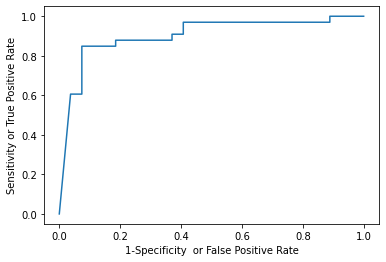

In [8]:
fpr_nb, tpr_nb, th_nb = roc_curve(cross_Y_test - 1, cross_y_test_prob[:,1])

plt.plot(fpr_nb, tpr_nb)
plt.xlabel("1-Specificity  or False Positive Rate")
plt.ylabel("Sensitivity or True Positive Rate")

#### Fourth:Calculate area under the curve(AUC)

In [9]:
auc_nb = roc_auc_score(cross_Y_test - 1, cross_y_test_prob[:,1])
print(auc_nb)

0.9023569023569024


#### Fifth:Draw the confusion matrix for evaluation

In [10]:
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))


In [11]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.PuRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Evaluation for: description
Classifier 'description' has Acc=0.850 P=0.857 R=0.855 F1=0.850
              precision    recall  f1-score   support

         1.0      0.926     0.781     0.847        32
         2.0      0.788     0.929     0.852        28

    accuracy                          0.850        60
   macro avg      0.857     0.855     0.850        60
weighted avg      0.862     0.850     0.850        60

Confusion matrix, without normalization
[[25  2]
 [ 7 26]]


c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

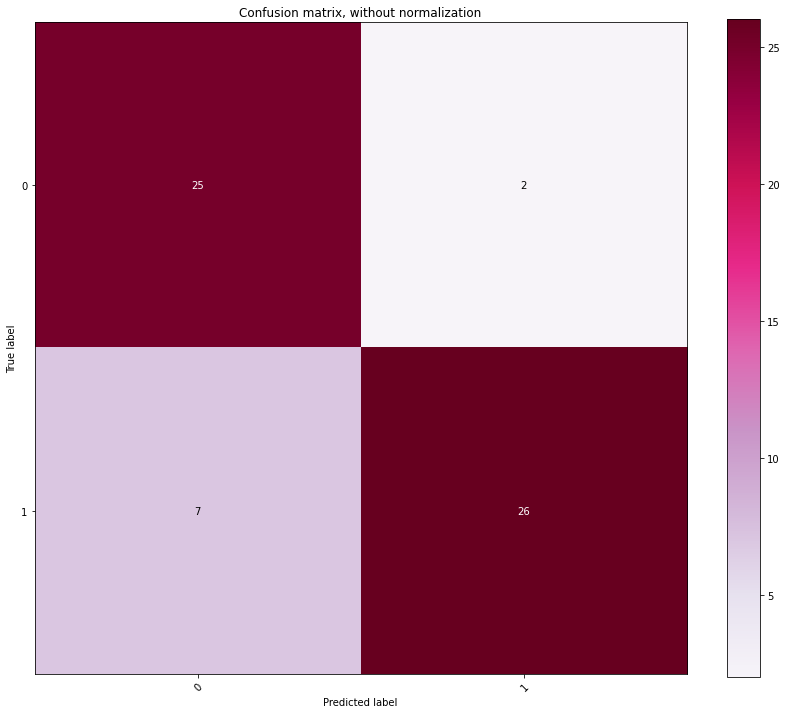

In [12]:
evaluation_summary("description", cross_y_test_pred, cross_Y_test)
plot_confusion_matrix(cross_Y_test, cross_y_test_pred,normalize=False,
                          title=None,
                          cmap=plt.cm.PuRd)

### 2.The proccess for subset of features by feature extraction

In [13]:
skb = SelectKBest(f_classif, k=50)
X_train_sub = skb.fit_transform(X_train, Y_train.ravel())
X_test_sub = skb.transform(X_test)
feature_list_extracted = feature_list[skb.get_support()]

model = LogisticRegression()
rfe = RFE(model,10)
fit = rfe.fit(X_train_sub, Y_train.ravel())
X_train_sub = fit.transform(X_train_sub)
X_test_sub = fit.transform(X_test_sub)

feature_list_final = feature_list_extracted[rfe.get_support()]
print(feature_list_final)


Y_train_sub = Y_train

c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


['SkewnessLayer1' 'RatioLayer3' 'ContrasttoneighborpixelsLayer33'
 'HSITransformationHueRLayer1GLayer2BLayer3' 'Areaofsubobjectsmean1Pxl'
 'Areaofsubobjectsstddev1Pxl' 'GLCMHomogeneityquick811Layer1alldir'
 'GLCMContrastquick811Layer1alldir' 'GLCMMeanquick811Layer1alldir'
 'AreaofsubobjectsNucleus1Pxl']


##### 2.1..Train data with cross validation to calculate the avarage accuracy and observe average accuracy

In [14]:
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

results_sub = []


    
for train_index_sub, test_index_sub in kf.split(X_train_sub):
    #print("TRAIN:", train_index, "TEST:", test_index)
    cross_fold_X_train_sub, cross_fold_X_test_sub = X_train_sub[train_index_sub], X_train_sub[test_index_sub]
    cross_fold_Y_train_sub, cross_fold_Y_test_sub = Y_train_sub[train_index_sub].flatten(), Y_train_sub[test_index_sub].flatten()
    #cross_fold_priori_sub, cross_fold_stats_sub = nb_train(cross_fold_X_train_sub, cross_fold_Y_train_sub)
    #cross_fold_y_test_pred_sub, cross_fold_y_test_prob_sub = predict(cross_fold_priori_sub, cross_fold_stats_sub, cross_fold_X_test_sub)
    model.fit(cross_fold_X_train_sub,cross_fold_Y_train_sub)
    cross_fold_y_test_pred_sub = model.predict(cross_fold_X_test_sub)


    results_sub.append(np.mean(cross_fold_Y_test_sub == cross_fold_y_test_pred_sub))
print(results_sub)

temp = 0
for i in results_sub:
    temp += i
print("The average accuracy :",temp/len(results_sub))



[0.85, 0.95, 0.9, 0.85, 0.85, 1.0, 0.85, 1.0, 1.0, 0.7, 0.95, 0.85, 0.95, 0.85, 0.9, 0.9, 0.9, 1.0, 0.95, 0.85, 0.9, 0.95, 0.8, 0.95, 0.95, 0.95, 0.8, 0.9, 0.9, 0.85, 1.0, 1.0, 1.0, 0.85, 0.9, 0.85, 0.8, 0.85, 0.9, 0.85, 0.85, 0.9, 0.9, 1.0, 0.95, 0.9, 0.9, 0.9, 0.9, 0.85, 0.9, 0.95, 0.75, 0.9, 0.95, 0.85, 0.75, 0.9, 0.95, 1.0, 0.8, 0.85, 0.9, 0.95, 0.95, 0.75, 0.95, 0.95, 0.85, 0.9, 0.8, 0.9, 0.95, 0.95, 1.0, 0.95, 0.85, 0.95, 0.9, 0.85, 0.95, 0.95, 0.9, 0.85, 0.95, 0.9, 0.9, 0.95, 0.8, 0.95, 0.85, 0.9, 0.9, 1.0, 0.95, 1.0, 0.95, 0.9, 0.95, 0.75]
The average accuracy : 0.9015000000000005


##### 2.2.Split train data into cross_train and cross_test to observe the accuracy（0/1 loss),draw the ROC and calculate AUC and confusion matrix with evaluation


#### First:split the training data into cross_train and cross_test data 

In [15]:
cross_X_train_sub, cross_X_test_sub, cross_Y_train_sub, cross_Y_test_sub = train_test_split(X_train_sub,Y_train_sub, test_size=0.3,random_state=28)
ctrain = Counter(cross_Y_train_sub.flatten())
ctest =  Counter(cross_Y_test_sub.flatten())
print(ctrain)
print(ctest)

Counter({2.0: 73, 1.0: 67})
Counter({2.0: 33, 1.0: 27})


#### second: Do the Naive Bayesian prediction on cross_data for evaluating accuracy

In [16]:
cross_X_train_sub, cross_Y_train_sub = cross_X_train_sub, cross_Y_train_sub.flatten()
cross_X_test_sub, cross_Y_test_sub = cross_X_test_sub, cross_Y_test_sub.flatten()

model.fit(cross_X_train_sub,cross_Y_train_sub)
cross_y_test_pred_sub = model.predict(cross_X_test_sub)


cross_y_test_prob_sub = model.predict_proba(cross_X_test_sub)
    
#cross_priori_sub, cross_stats_sub = nb_train(cross_X_train_sub, cross_Y_train_sub)
#cross_y_test_pred_sub, cross_y_test_prob_sub = predict(cross_priori_sub, cross_stats_sub, cross_X_test_sub)
    
print("The accuracy for Naive Baesian classifier with subset features:",np.mean(cross_Y_test_sub == cross_y_test_pred_sub))

The accuracy for Naive Baesian classifier with subset features: 0.9


#### Third:Draw the ROC graph for evaluating

Text(0, 0.5, 'Sensitivity or True Positive Rate')

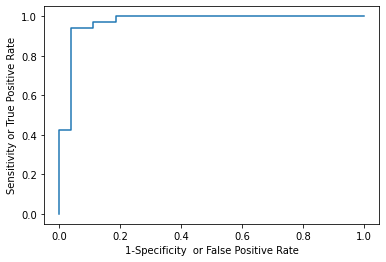

In [17]:
fpr_nb_sub, tpr_nb_sub, th_nb_sub = roc_curve(cross_Y_test_sub - 1, cross_y_test_prob_sub[:,1])

plt.plot(fpr_nb_sub, tpr_nb_sub)
plt.xlabel("1-Specificity  or False Positive Rate")
plt.ylabel("Sensitivity or True Positive Rate")

#### Fourth:Calculate area under the curve(AUC)

In [18]:
auc_nb = roc_auc_score(cross_Y_test_sub - 1, cross_y_test_prob_sub[:,1])
print(auc_nb)

0.9719416386083053


#### Fifth:Draw the confusion matrix for evaluation

Evaluation for: description
Classifier 'description' has Acc=0.900 P=0.906 R=0.902 F1=0.900
              precision    recall  f1-score   support

         1.0      0.963     0.839     0.897        31
         2.0      0.848     0.966     0.903        29

    accuracy                          0.900        60
   macro avg      0.906     0.902     0.900        60
weighted avg      0.908     0.900     0.900        60

Confusion matrix, without normalization
[[26  1]
 [ 5 28]]


c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

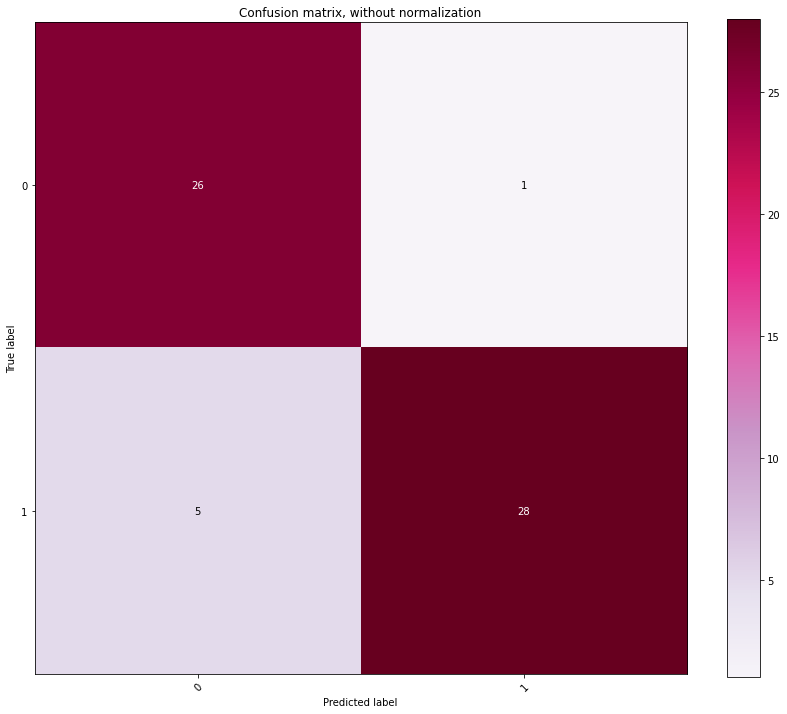

In [19]:
evaluation_summary("description", cross_y_test_pred_sub, cross_Y_test_sub)
plot_confusion_matrix(cross_Y_test_sub, cross_y_test_pred_sub,normalize=False,
                          title=None,
                          cmap=plt.cm.PuRd)

##### 2.3.Predict the Y_test for submission with the classifier

In [20]:
X_train_sub,Y_train_sub = X_train_sub,Y_train_sub.flatten()

model.fit(X_train_sub,Y_train_sub)
y_test_pred = model.predict(X_test_sub)


#priori_sub, stats_sub = nb_train(X_train_sub,Y_train_sub)
#y_test_pred, y_test_prob = predict(priori_sub, stats_sub,X_test_sub)
print(y_test_pred.shape)

(798,)


In [21]:
test_header = "Id,EpiOrStroma"
n_points = X_test_sub.shape[0]
print(X_test_sub.shape[0])
y_pred_pp_b = np.ones((n_points, 2))
y_pred_pp_b[:, 0] = range(n_points)
y_pred_pp_b[:, 1] = y_test_pred
print(y_pred_pp_b)
np.savetxt('my_submission_Naive_Bayesian_cl.csv', y_pred_pp_b, fmt='%d', delimiter=",",header=test_header, comments="")

798
[[  0.   2.]
 [  1.   2.]
 [  2.   2.]
 ...
 [795.   1.]
 [796.   2.]
 [797.   2.]]


### 3.Compare the performance of NB with whole features and subset of features with feature extraction

#### The performance for the whole feature data using Naive Bayesian classifer sharing the average accuracy around 0.831 with Repeated K-fold cross validation,whereas the performance for subset of feature data using Naive Bayesian classifer sharing the average accuracy around 0.9015 using Repeated k-fold cross validation,which indicate the for Naive Bayesian classifer classifier ,the accuracy might be higher for that classifier if we deploy important features


#### The ROC for Naive bayes classifier with all features(Blue) and subset of features(orange) is sketched below

Text(0, 0.5, 'Sensitivity or True Positive Rate')

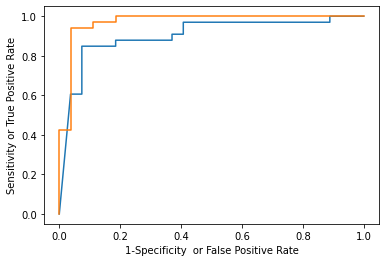

In [22]:
plt.plot(fpr_nb, tpr_nb)
plt.plot(fpr_nb_sub, tpr_nb_sub)

plt.xlabel("1-Specificity  or False Positive Rate")
plt.ylabel("Sensitivity or True Positive Rate")